In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate();

  Activating environment at `~/Julia/CDC-2022/Project.toml`
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Cur

In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using CSV
using DataFrames
using MAT
using JLD
using Parameters
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1317


In [3]:
import ReactiveMP.messageout

In [4]:
data_seed, params_seed = 42, 420

(42, 420)

### Load data

In [5]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [6]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

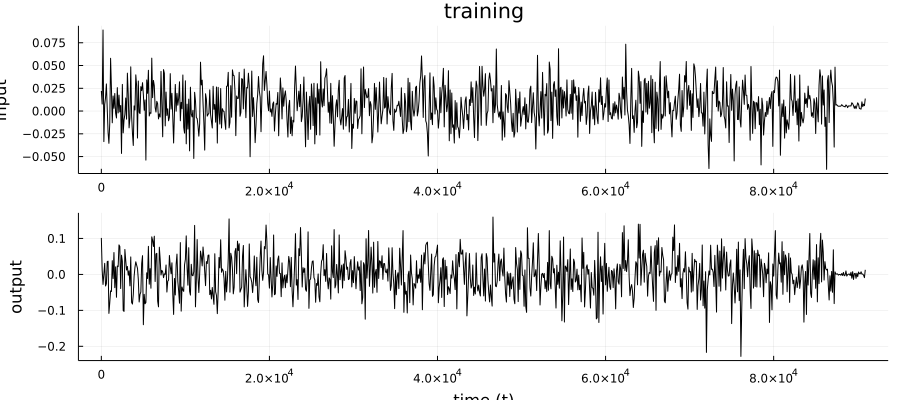

In [7]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

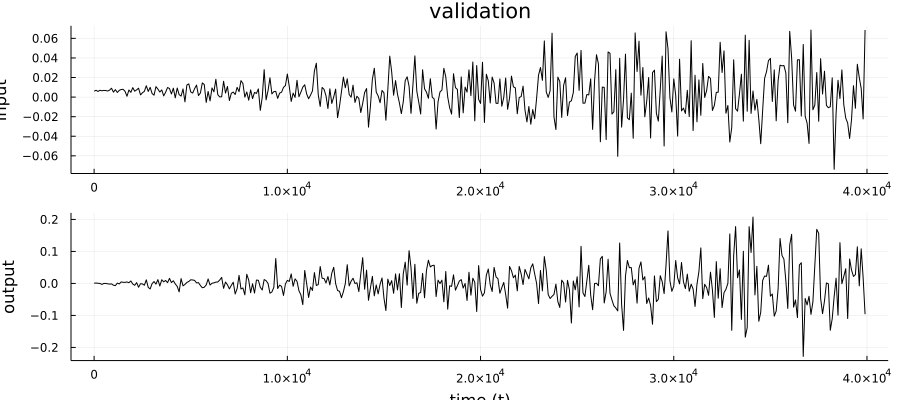

In [8]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### Model

In [9]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end

In [285]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    proxy_message_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    marginal_in = prod(ProdAnalytical(), proxy_message_in, m_in)
    
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [286]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [287]:
melu(x) = clamp(x, convert(Float64, tiny), Inf)
Float64(x::HugeNumber) = convert(Float64, x)

Float64

In [288]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h+1); H[full_order-order_h+1:full_order, 2:order_h+1] = diageye(order_h);

In [316]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [686]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e1;
    obs_prec = 1e1
    b = ones(order);
#     b = zeros(order); b[1] = 1.0;
    
    params_flow = model_params[1:end-2]
    params_w    = model_params[end-1:end]
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))}
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
#     Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order))
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order+1, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    θ ~ MvNormalMeanPrecision(zeros(h_order+1), prec*diageye(h_order+1))
    
    S = shift(order_h+1);
    c = zeros(order_h+1); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
#         h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t] + dot(h[t], c), obs_prec) where { q = MeanField()}
        h_prev = h[t]
    end

    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
end

nonlinear_max_mv (generic function with 1 method)

In [687]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order+1), 0.1*diageye(h_order+1)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    params_w    = params[end-1:end]
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    
    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [688]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

### Prepare data

In [689]:
train_size = 800
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [690]:
X_train, Y_train, U_train = 100*X_train, 100*Y_train, 100*U_train
X_test, Y_test, U_test = 100*X_test, 100*Y_test, 100*U_test

([[0.155, 0.085876], [0.14943, 0.155], [0.090809, 0.14943], [0.011911999999999999, 0.090809], [-0.054597999999999994, 0.011911999999999999], [-0.03157, -0.054597999999999994], [0.084718, -0.03157], [0.18941, 0.084718], [0.19567, 0.18941], [0.12546000000000002, 0.19567]  …  [0.030300999999999998, -0.17266], [0.2999, 0.030300999999999998], [0.48822, 0.2999], [0.55058, 0.48822], [0.45775, 0.55058], [0.20357999999999998, 0.45775], [-0.11832999999999999, 0.20357999999999998], [-0.40431, -0.11832999999999999], [-0.58304, -0.40431], [-0.56085, -0.58304]], [0.14943, 0.090809, 0.011911999999999999, -0.054597999999999994, -0.03157, 0.084718, 0.18941, 0.19567, 0.12546000000000002, 0.05471500000000001  …  0.2999, 0.48822, 0.55058, 0.45775, 0.20357999999999998, -0.11832999999999999, -0.40431, -0.58304, -0.56085, -0.30571000000000004], [[0.5468999999999999, 0.59927], [0.58692, 0.5468999999999999], [0.57779, 0.58692], [0.54767, 0.57779], [0.6818099999999999, 0.54767], [0.74466, 0.6818099999999999], [

### Train model

In [695]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; [1e3, 1.0]]

47-element Vector{Float64}:
   -0.3179695928057278
    0.9776221095017685
   -1.302121139959913
   -0.22534055313176568
    2.2260446301077863
    0.9394246742858201
    1.1017041528684897
    0.7890058448820707
   -0.11671547310971386
    2.643745143350261
    0.9916863399279355
   -2.722437547850197
    0.02618265942906552
    ⋮
   -0.6872406235719013
    0.06550923534707748
    0.09390033919201733
    0.08932143945409336
   -1.0430456969754591
   -0.5358295376206549
   -0.14097933066681662
    0.056465626521546956
   -1.3598184537391496
   -0.4756875171164519
 1000.0
    1.0

In [696]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


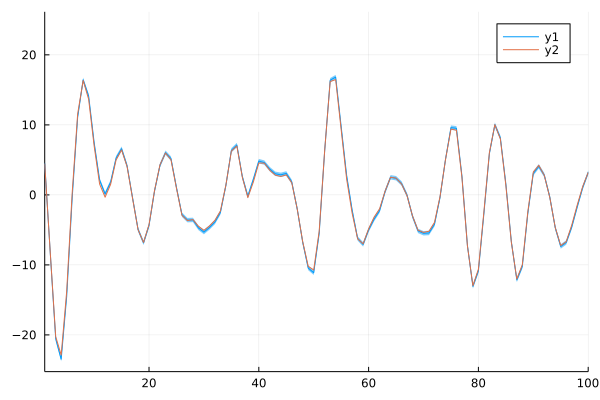

In [697]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 100))

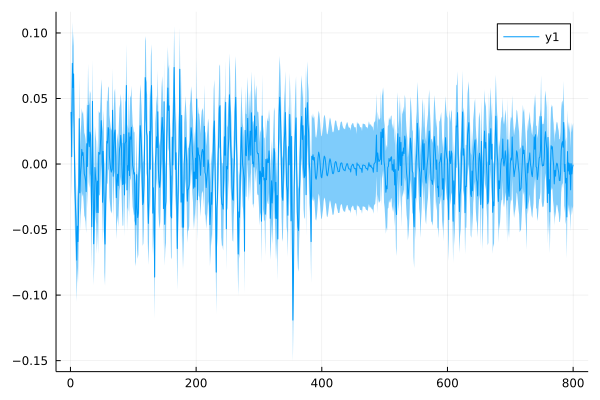

In [698]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))
# plot!(h_gen, xlims=(mfrom, mto))

In [625]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=1);
    
    return fe_[end]
end;

In [636]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     3.878822e+04     3.534035e+04
 * time: 0.0017161369323730469
     1     2.975431e+04     1.031142e+04
 * time: 58.948384046554565
     2     1.497045e+04     8.157100e+03
 * time: 67.29848098754883
     3     1.440855e+04     8.004821e+03
 * time: 79.35567498207092
     4     1.282188e+04     1.169132e+03
 * time: 88.02733516693115
     5     1.258002e+04     2.589150e+03
 * time: 108.17901802062988
     6     1.228605e+04     9.548986e+02
 * time: 118.0401120185852
     7     1.203628e+04     2.322616e+03
 * time: 129.96950101852417
     8     1.169766e+04     2.802129e+03
 * time: 137.95237517356873
     9     1.145054e+04     1.306618e+03
 * time: 149.8596670627594
    10     1.134012e+04     1.075849e+03
 * time: 157.14163208007812
    11     1.122042e+04     1.453360e+03
 * time: 169.36728310585022
    12     1.106173e+04     1.513739e+03
 * time: 180.3885190486908
    13     1.091697e+04     1.183866e+03
 * time: 188.39389014244

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     8.730157e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 4.72e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.91e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.19e+01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.95e-03 ≰ 0.0e+00
    |g(x)|                 = 1.56e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   736  (vs limit Inf)
    Iterations:    50
    f(x) calls:    140
    ∇f(x) calls:   140


In [638]:
inf_params = Optim.minimizer(res)
# inf_params = model_params

47-element Vector{Float64}:
 -0.8324128804276825
  1.0550305884527882
 -1.2384649415895401
 -0.12206412226101843
  1.3268777924936008
  4.076940584056225
 -0.5779460468987385
 -3.321685541499418
  4.752299074111829
  2.3034793969795846
 -0.43080493363062417
 -3.169265379056889
 -0.00662032718277708
  ⋮
 -0.5752254609680222
 -1.0881985246244694
  0.20666194552390071
  0.6165116719061531
 -0.6022826884781269
 -0.4987988534772738
 -0.3242097248784674
  0.39062885127295205
 -1.3587301391838784
 -0.5360194092867113
  9.606276853414785
  3.0138543626140275

In [667]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


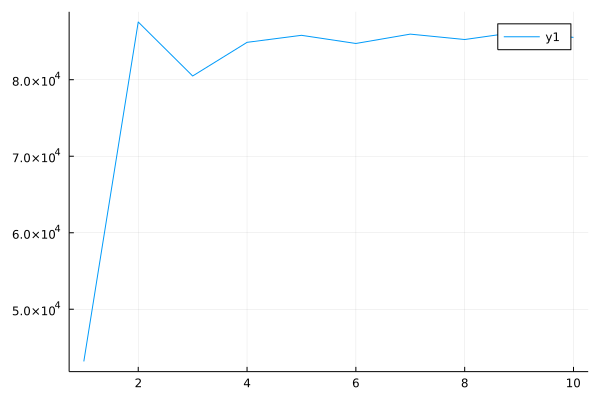

In [668]:
plot(fe_)

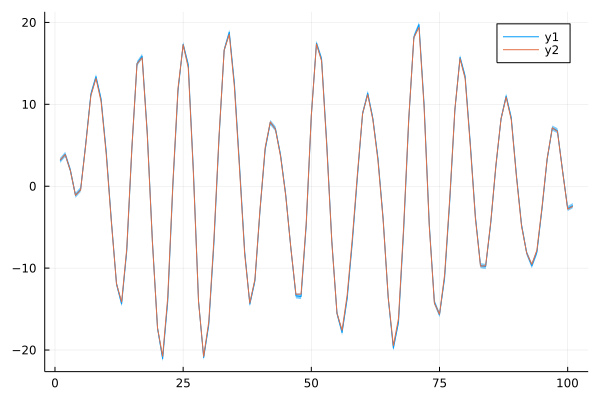

In [669]:
from, to = 100, 200
plot(mean.(y_out_[from:to]), ribbon=sqrt.(cov.(y_out_[from:to])))
plot!(Y_train[from:to])

In [670]:
mean.(h_)

800-element Vector{Vector{Float64}}:
 [1.529309702112434, -15.374553557336947, -11.901249859720545]
 [8.410219471093628, 1.6260282177418568, -15.390035756709876]
 [7.196873593458765, 8.521815355587718, 1.5564086568201092]
 [14.677856373346303, 5.7322894354850895, 8.522934119941272]
 [16.649030734333284, 13.10169176164377, 6.995740520126456]
 [2.568521965967225, 18.106844240400683, 13.43746515487123]
 [-2.905196916584798, 2.522015992679321, 17.64170165028893]
 [-12.525854320232865, -2.9112452788646133, 2.5810433834671445]
 [-5.834264980212887, -12.453298560137963, -2.916393777823175]
 [-9.100953056131821, -6.240621031955165, -12.662753666203798]
 [-9.033793906017204, -9.162176015287569, -6.108597734473287]
 [-3.468510893271254, -9.034632462855779, -9.14764742689463]
 [-6.185595955963145, -3.407279584658222, -9.035729385620943]
 ⋮
 [-1.3798862732747919, -3.878932674395446, -0.23394602149604082]
 [-2.8576587756243343, -1.2527632857491902, -3.8730833295950724]
 [0.7211086164093848, -2.7328

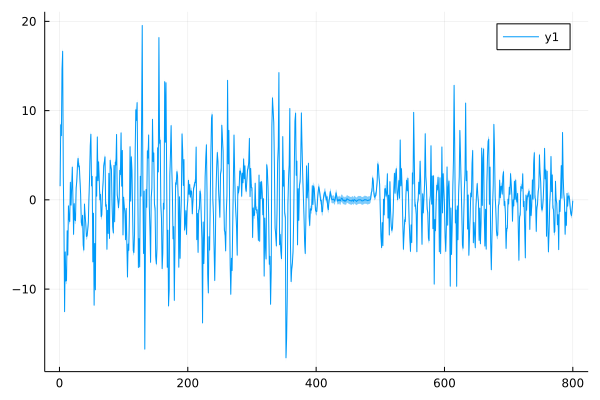

In [671]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [672]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [0.13755745812345316 -0.03596853957981845 0.031815775986984235; -0.03596853957981845 0.4178071376306925 -0.36956903037786054; 0.031815775986984235 -0.36956903037786054 2.231928169294085]
 [0.14498480313187387 -0.005845515060274274 0.0015256709722055641; -0.005845515060274274 0.1373997764955187 -0.03586114284630882; 0.0015256709722055641 -0.03586114284630882 0.4172082796294448]
 [0.14765820962861015 -0.006991387789961116 0.00029080923966312734; -0.006991387789961116 0.1453787570856546 -0.006047080648559596; 0.00029080923966312734 -0.006047080648559596 0.1374821914142376]
 [0.16811644055594252 -0.019685082432716283 0.0009267482915190856; -0.019685082432716283 0.14928114993588212 -0.007027963999233975; 0.0009267482915190856 -0.007027963999233975 0.1453135398799696]
 [0.1604965739865174 -0.020846834874687303 0.0019714936418015663; -0.020846834874687303 0.16619007368715077 -0.015716662772754186; 0.0019714936418015663 -0.015716662772754186 0.147433553553

## KF-like prediction

In [699]:
function transition(γ, order)
#     V = zeros(order, order)
    V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [740]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    prec = 1e1
    h_order = length(h_prior[1])
    b = ones(full_order);
#     b = zeros(full_order); b[1] = 1.0;
    

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)
    c = zeros(h_order); c[1] = 1.0

    # initialize variables
    y_pred   = datavar(Float64)
    
#     Ys = Y*y_prev
#     Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, inf_params[1:end-2]), Linearization()) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    Ys ~ MvNormalMeanPrecision(Y*y_prev, prec*diageye(full_order))
    Us ~ MvNormalMeanPrecision(U*u, prec*diageye(full_order))

    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation(), pipeline = RequireInbound(in )}
#     y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation()}
    
    y_lat_2 ~ dot(y_lat_1, b)

    y_node, y ~ NormalMeanVariance(y_lat_2 + dot(h, c), inv(prec))
    
    y_pred ~ NormalMeanVariance(y, 1e12)
#     y ~ Uninformative()
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [744]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
#     setmarginal!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [747]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
all_h = [h_prev]
ŵ = model_params[end-1:end][1]/model_params[end-1:end][2]
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=50)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, h_prior=h_prev, u_order=order_u, h_order=order_h, vmp_its=1);
#     h_prev = (mean.(h_inf)[end], precision.(h_inf)[end])
    push!(all_h, h_prev)
    
end

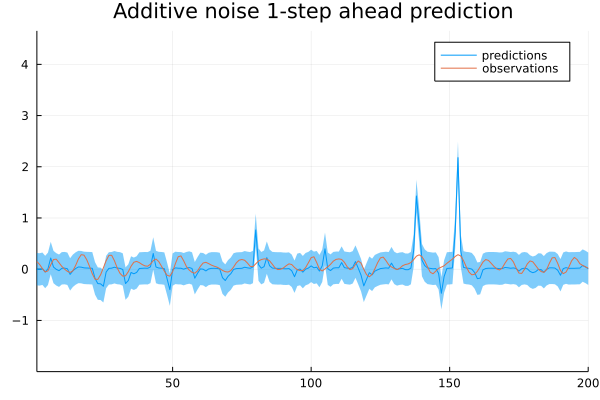

In [748]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 200), title="Additive noise 1-step ahead prediction", label="observations")